In [1]:
%load_ext autoreload
%autoreload 2
import sys
#sys.path.insert(1, '/home/ximo/Documents/GitHub/skforecast')
%config Completer.use_jedi = False

In [1]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

In [2]:
import session_info
session_info.show(html=False, write_req_file=False)

-----
matplotlib          3.4.3
numpy               1.19.5
pandas              1.3.0
session_info        1.0.0
skforecast          0.4.2
sklearn             1.0.1
-----
IPython             7.27.0
jupyter_client      6.1.12
jupyter_core        4.7.1
jupyterlab          3.1.11
notebook            6.3.0
-----
Python 3.7.10 (default, Feb 26 2021, 18:47:35) [GCC 7.3.0]
Linux-5.11.0-43-generic-x86_64-with-debian-bullseye-sid
-----
Session information updated at 2022-01-02 13:39


# Data

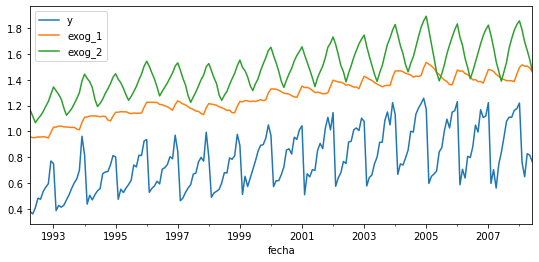

In [3]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv')
data = pd.read_csv(url, sep=',')

# data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.plot(ax=ax);

# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

# ForecasterAutoregMultiOutput without exogenous variables

In [4]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = make_pipeline(StandardScaler(), Ridge()),
                    steps     = 36,
                    lags      = 10
                )

forecaster.fit(data_train.y)
forecaster

ForecasterAutoregMultiOutput 
Regressor: Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]) 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Window size: 10 
Maximum steps predicted: 36 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'ridge__alpha': 1.0, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__normalize': 'deprecated', 'ridge__positive': False, 'ridge__random_state': None, 'ridge__solver': 'auto', 'ridge__tol': 0.001} 
Creation date: 2022-01-02 13:39:04 
Last fit date: 2022-01-02 13:39:04 
Skforecast version: 0.4.2 

In [5]:
forecaster.get_coef(step=1)

,feature,coef
0,lag_1,0.101614
1,lag_2,-0.004904
2,lag_3,0.013985
3,lag_4,-0.012582
4,lag_5,-0.005272
5,lag_6,-0.003644
6,lag_7,-0.008144
7,lag_8,0.001939
8,lag_9,0.011023
9,lag_10,0.044417


Test error (mse): 0.010462358038493989


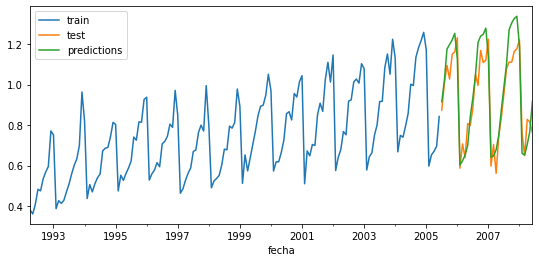

In [6]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=36)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test.y,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [7]:
# Grid search hiperparameters and lags
# ==============================================================================
steps = 36
regressor = Ridge()

forecaster = ForecasterAutoregMultiOutput(
                regressor = regressor,
                steps     = steps,
                lags      = 5 
             )

# Regressor hiperparameters
param_grid ={'alpha': [0.01, 0.1, 1]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.y,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = steps,
                        metric      = 'mean_squared_error',
                        refit       = False,
                        initial_train_size  = int(len(data)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid.head(4)

Number of models compared: 9


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:00<00:00,  3.32it/s]


Refitting `forecaster` using the best found lags and parameters and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 0.03132038312603389



,lags,params,metric,alpha
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'alpha': 0.01},0.031320,0.01
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'alpha': 0.1},0.032115,0.10
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'alpha': 1},0.041186,1.00
8,"[1, 2, 3, 20]",{'alpha': 1},0.076195,1.00


In [7]:
# Predictors importance
# ==============================================================================
# for step in range(forecaster.steps):
#     print("Feature importance model step: ", step+1)
#     display(forecaster.get_coef(step=step+1))
#     print("")

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 115
Number of observations used for backtesting: 80
    Number of folds: 2
    Number of steps per fold: 65
    Last fold only includes 15 observations

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 2001-10-01 00:00:00
    Validation: 2001-11-01 00:00:00 -- 2007-03-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2001-10-01 00:00:00
    Validation: 2007-04-01 00:00:00 -- 2008-06-01 00:00:00

[0.02946123]


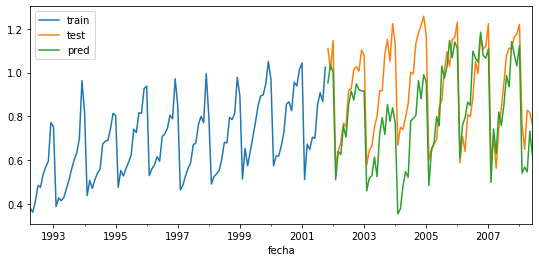

In [8]:
# Backtesting
# ==============================================================================
steps = 65
n_backtest = 40*2
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]


forecaster = ForecasterAutoregMultiOutput(
                    regressor = LinearRegression(),
                    steps     = steps,
                    lags      = 15
             )

metrica, predicciones_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = data.y,
    initial_train_size = len(data_train),
    steps      = steps,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = True
)
print(metrica)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predictions')
ax.legend();

In [9]:
predicciones_backtest

,pred
2001-11-01,0.952475
2001-12-01,1.034850
2002-01-01,1.001239
2002-02-01,0.510238
2002-03-01,0.639579
...,...
2008-02-01,0.540224
2008-03-01,0.568002
2008-04-01,0.545885
2008-05-01,0.732472


In [10]:
forecaster.fit(y=data_train.y)
predictions_1 = forecaster.predict(steps=steps)
predictions_2 = forecaster.predict(steps=15, last_window=data_test.y[:steps])
np.allclose(predicciones_backtest.pred, np.concatenate([predictions_1, predictions_2]))

True

# ForecasterAutoregMultiOutput with 1 exogenous variables

In [11]:
# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

In [12]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = Ridge(),
                    steps     = 36,
                    lags      = 10
                )

forecaster.fit(y=data_train.y, exog=data_train.exog_1)
forecaster

ForecasterAutoregMultiOutput 
Regressor: Ridge() 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Window size: 10 
Maximum steps predicted: 36 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: exog_1 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001} 
Creation date: 2022-01-02 13:39:40 
Last fit date: 2022-01-02 13:39:40 
Skforecast version: 0.4.2 

In [13]:
forecaster.get_coef(step=2)

,feature,coef
0,lag_1,0.164484
1,lag_2,0.037260
2,lag_3,-0.041879
3,lag_4,-0.068689
4,lag_5,-0.071900
5,lag_6,-0.055700
6,lag_7,-0.057170
7,lag_8,0.036523
8,lag_9,0.073948
9,lag_10,0.406170


Test error (mse): 0.00810760566140999


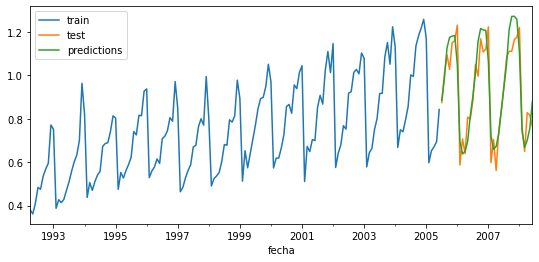

In [14]:
# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=data_test.exog_1)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error prediction
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test.y,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

In [15]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = RandomForestRegressor(random_state=123),
                    steps     = 36,
                    lags      = 10
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train.y,
                        exog        = data_train.exog_1,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 36,
                        metric      = 'mean_squared_error',
                        refit       = False,
                        initial_train_size = int(len(data_train)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid.head(4)

Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:30<00:00, 10.02s/it]


Refitting `forecaster` using the best found lags and parameters and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 0.04203503397538376



,lags,params,metric,max_depth,n_estimators
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.042035,10,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.042439,5,100
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.042818,10,50
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.042879,5,50


In [19]:
# Backtesting
# ==============================================================================
steps      = 36
n_backtest = 36 * 3
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

forecaster = ForecasterAutoregMultiOutput(
                regressor = Ridge(),
                steps     = steps,
                lags      = 5 
             )

metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    exog       = data.exog_1,
                                    initial_train_size = len(data_train),
                                    steps      = steps,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                                )

print(metrica)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number of steps per fold: 36

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00
    Validation: 1999-07-01 00:00:00 -- 2002-06-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00
    Validation: 2002-07-01 00:00:00 -- 2005-06-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00

[0.09317934]


In [20]:
# Verificar predicciones de backtesting
forecaster.fit(y=data_train.y, exog=data_train.exog_1)
predictions_1 = forecaster.predict(steps=steps, exog=data_test.exog_1[:steps])
predictions_2 = forecaster.predict(steps=steps, last_window=data_test.y[:steps], exog=data_test.exog_1[steps:steps*2])
predictions_3 = forecaster.predict(steps=steps, last_window=data_test.y[steps:steps*2], exog=data_test.exog_1[steps*2:steps*3])
np.allclose(predicciones_backtest.pred, np.concatenate([predictions_1, predictions_2, predictions_3]))

True

# ForecasterAutoregMultiOutput with multiple exogenous variables

In [21]:
# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

In [24]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = RandomForestRegressor(),
                    steps     = 36,
                    lags      = 10
                )

forecaster.fit(y=data_train['y'], exog=data_train[['exog_1', 'exog_2']])
forecaster

ForecasterAutoregMultiOutput 
Regressor: RandomForestRegressor() 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Window size: 10 
Maximum steps predicted: 36 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['exog_1', 'exog_2'] 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-01-02 13:42:18 
Last fit date: 2022-01-02 13:42:22 
Skforecast version: 0.4.2 

In [25]:
forecaster.get_feature_importance(step=1)

,feature,importance
0,lag_1,0.367952
1,lag_2,0.160738
2,lag_3,0.034382
3,lag_4,0.027256
4,lag_5,0.017207
5,lag_6,0.017995
6,lag_7,0.038191
7,lag_8,0.021107
8,lag_9,0.024069
9,lag_10,0.088084


Test error (mse): 0.004939977907341052


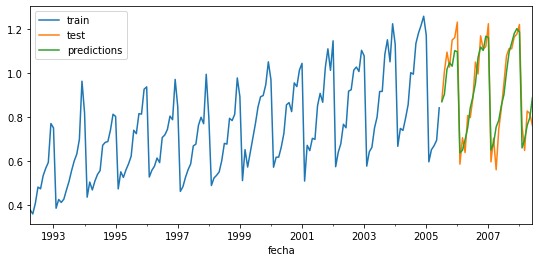

In [26]:
# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=data_test[['exog_1', 'exog_2']])

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test.y,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

In [27]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = RandomForestRegressor(),
                    steps     = 36,
                    lags      = 10
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train['y'],
                        exog        = data_train[['exog_1', 'exog_2']],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 36,
                        metric      = 'mean_squared_error',
                        refit       = False,
                        initial_train_size    = int(len(data_train)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:32<00:00, 10.91s/it]


Refitting `forecaster` using the best found lags and parameters and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 0.037637117801813266



,lags,params,metric,max_depth,n_estimators
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.037637,10,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.037824,5,100
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.038229,5,50
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.038519,10,50
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.039357,5,50
9,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.039487,5,100
10,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.040277,10,50
11,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 100}",0.041300,10,100
2,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 50}",0.044629,10,50
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.045291,5,100


# Unit testing

In [28]:
# Unit test create_train_X_y
# ==============================================================================

import pytest
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from sklearn.linear_model import LinearRegression

def test_create_train_X_y_output_when_lags_3_steps_1_and_exog_is_None():
    '''
    Test output of create_train_X_y when regressor is LinearRegression, lags is 3
    and steps is 1.
    '''
    forecaster = ForecasterAutoregMultiOutput(LinearRegression(), lags=3, steps=1)
    results = forecaster.create_train_X_y(y=pd.Series(np.arange(10)))
    expected = (pd.DataFrame(
                    data = np.array([[2., 1., 0.],
                                    [3., 2., 1.],
                                    [4., 3., 2.],
                                    [5., 4., 3.],
                                    [6., 5., 4.],
                                    [7., 6., 5.],
                                    [8., 7., 6.]]),
                    index   = np.array([3, 4, 5, 6, 7, 8, 9]),
                    columns = ['lag_1', 'lag_2', 'lag_3']
                ),
                pd.DataFrame(
                    np.array([3., 4., 5., 6., 7., 8., 9.]),
                    index = np.array([3, 4, 5, 6, 7, 8, 9]),
                    columns = ['y_step_0'])
               )  
 
    pd.testing.assert_frame_equal(results[0], expected[0])
    pd.testing.assert_frame_equal(results[1], expected[1])


def test_create_train_X_y_output_when_lags_3_steps_2_and_exog_is_None():
    '''
    Test output of create_train_X_y when regressor is LinearRegression, lags is 3
    and steps is 2.
    '''
    forecaster = ForecasterAutoregMultiOutput(LinearRegression(), lags=3, steps=2)
    results = forecaster.create_train_X_y(y=pd.Series(np.arange(10)))
    expected = (pd.DataFrame(
                    data = np.array([[2., 1., 0.],
                                    [3., 2., 1.],
                                    [4., 3., 2.],
                                    [5., 4., 3.],
                                    [6., 5., 4.],
                                    [7., 6., 5.]]),
                    index   = np.array([4, 5, 6, 7, 8, 9]),
                    columns = ['lag_1', 'lag_2', 'lag_3']
                ),
                pd.DataFrame(
                    np.array([[3., 4.],
                             [4., 5.],
                             [5., 6.],
                             [6., 7.],
                             [7., 8.],
                             [8., 9.]]),
                    index = np.array([4, 5, 6, 7, 8, 9]),
                    columns = ['y_step_0', 'y_step_1'])
               )  
 
    pd.testing.assert_frame_equal(results[0], expected[0])
    pd.testing.assert_frame_equal(results[1], expected[1])
    
    

def test_create_train_X_y_output_when_lags_5_steps_1_and_exog_is_series():
    '''
    Test output of create_train_X_y when regressor is LinearRegression, lags is 5,
    steps is 1 and exog is pandas Series.
    '''
    forecaster = ForecasterAutoregMultiOutput(LinearRegression(), lags=5, steps=1)
    results = forecaster.create_train_X_y(
                    y = pd.Series(np.arange(10)),
                    exog = pd.Series(np.arange(100, 110), name='exog')
                )
    expected = (pd.DataFrame(
                    data = np.array([[4., 3., 2., 1., 0., 105.],
                                     [5., 4., 3., 2., 1., 106.],
                                     [6., 5., 4., 3., 2., 107.],
                                     [7., 6., 5., 4., 3., 108.],
                                     [8., 7., 6., 5., 4., 109.]]),
                    index = np.array([5, 6, 7, 8, 9]),
                    columns = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'exog_step_1']
                ),
                pd.DataFrame(
                    np.array([[5.],
                             [6.],
                             [7.],
                             [8.],
                             [9.]]),
                    index = np.array([5, 6, 7, 8, 9]),
                    columns = ['y_step_0'])
               )    

    pd.testing.assert_frame_equal(results[0], expected[0])
    pd.testing.assert_frame_equal(results[1], expected[1])


def test_create_train_X_y_output_when_lags_5_steps_2_and_exog_is_series():
    '''
    Test output of create_train_X_y when regressor is LinearRegression, lags is 5,
    steps is 2 and exog is pandas Series.
    '''
    forecaster = ForecasterAutoregMultiOutput(LinearRegression(), lags=5, steps=2)
    results = forecaster.create_train_X_y(
                    y = pd.Series(np.arange(10)),
                    exog = pd.Series(np.arange(100, 110), name='exog')
                )
    expected = (np.array([[  4., 3., 2., 1., 0., 105., 106.],
                        [  5., 4., 3., 2., 1., 106., 107.],
                        [  6., 5., 4., 3., 2., 107., 108.],
                        [  7., 6., 5., 4., 3., 108., 109.]]),
                np.array([[5., 6.],
                        [6., 7.],
                        [7., 8.],
                        [8., 9.]]))   

    expected = (pd.DataFrame(
                    data = np.array([[  4., 3., 2., 1., 0., 105., 106.],
                                    [  5., 4., 3., 2., 1., 106., 107.],
                                    [  6., 5., 4., 3., 2., 107., 108.],
                                    [  7., 6., 5., 4., 3., 108., 109.]]),
                    index = np.array([6, 7, 8, 9]),
                    columns = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
                               'exog_step_1', 'exog_step_2']
                ),
                pd.DataFrame(
                    np.array([[5., 6.],
                            [6., 7.],
                            [7., 8.],
                            [8., 9.]]),
                    index = np.array([6, 7, 8, 9]),
                    columns = ['y_step_0', 'y_step_1'])
               )    

    pd.testing.assert_frame_equal(results[0], expected[0])
    pd.testing.assert_frame_equal(results[1], expected[1])
    

def test_create_train_X_y_output_when_lags_5_steps_1_y_is_range_10_and_exog_is_dataframe():
    '''
    Test output of create_train_X_y when regressor is LinearRegression, lags is 5,
    steps is 2 and exog is pandas dataframe.
    '''
    forecaster = ForecasterAutoregMultiOutput(LinearRegression(), lags=5, steps=1)
    results = forecaster.create_train_X_y(
                y = pd.Series(np.arange(10)),
                exog = pd.DataFrame({
                            'exog_1' : np.arange(100, 110),
                            'exog_2' : np.arange(1000, 1010)
                        })
              )  

    expected = (pd.DataFrame(
                    data = np.array([[4, 3, 2, 1, 0, 105, 1005],
                                    [5, 4, 3, 2, 1, 106, 1006],
                                    [6, 5, 4, 3, 2, 107, 1007],
                                    [7, 6, 5, 4, 3, 108, 1008],
                                    [8, 7, 6, 5, 4, 109, 1009]], dtype=float),
                    index = np.array([5, 6, 7, 8, 9]),
                    columns = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
                               'exog_1_step_1', 'exog_2_step_1']
                ),
                pd.DataFrame(
                    np.array([[5.],
                             [6.],
                             [7.],
                             [8.],
                             [9.]]),
                    index = np.array([5, 6, 7, 8, 9]),
                    columns = ['y_step_0'])
               )    

    pd.testing.assert_frame_equal(results[0], expected[0])
    pd.testing.assert_frame_equal(results[1], expected[1])

    
def test_create_train_X_y_output_when_lags_5_steps_3_and_and_exog_is_dataframe():
    '''
    Test output of create_train_X_y when regressor is LinearRegression, lags is 5,
    steps is 3 and exog is pandas dataframe.
    '''
    forecaster = ForecasterAutoregMultiOutput(LinearRegression(), lags=5, steps=3)
    results = forecaster.create_train_X_y(
                y = pd.Series(np.arange(10)),
                exog = pd.DataFrame({
                            'exog_1' : np.arange(100, 110),
                            'exog_2' : np.arange(1000, 1010)
                        })
              )

    expected = (pd.DataFrame(
                    data = np.array([[4, 3, 2, 1, 0, 105, 106, 107, 1005, 1006, 1007],
                                    [5, 4, 3, 2, 1, 106, 107, 108, 1006, 1007, 1008],
                                    [6, 5, 4, 3, 2, 107, 108, 109, 1007, 1008, 1009]],
                                    dtype=float),
                    index = np.array([7, 8, 9]),
                    columns = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
                               'exog_1_step_1', 'exog_1_step_2', 'exog_1_step_3',
                               'exog_2_step_1', 'exog_2_step_2', 'exog_2_step_3']
                ),
                pd.DataFrame(
                    np.array([[5, 6, 7],
                             [6, 7, 8],
                             [7, 8, 9]], dtype=float),
                    index = np.array([7, 8, 9]),
                    columns = ['y_step_0', 'y_step_1', 'y_step_2'])
               )    

    pd.testing.assert_frame_equal(results[0], expected[0])
    pd.testing.assert_frame_equal(results[1], expected[1])
    
test_create_train_X_y_output_when_lags_3_steps_1_and_exog_is_None()
test_create_train_X_y_output_when_lags_3_steps_2_and_exog_is_None()
test_create_train_X_y_output_when_lags_5_steps_1_and_exog_is_series()
test_create_train_X_y_output_when_lags_5_steps_2_and_exog_is_series()
test_create_train_X_y_output_when_lags_5_steps_1_y_is_range_10_and_exog_is_dataframe()
test_create_train_X_y_output_when_lags_5_steps_3_and_and_exog_is_dataframe()

/home/ximo/anaconda3/lib/python3.7/site-packages/skforecast/utils/utils.py:344: UserWarning: `exog` has DatetimeIndex index but no frequency. The index is overwritten with a RangeIndex.
  ('`exog` has DatetimeIndex index but no frequency. The index is '


In [29]:
# Unit test __init__
# ==============================================================================
import pytest
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from sklearn.linear_model import LinearRegression

def test_init_lags_when_integer():
    '''
    Test creation of attribute lags when integer is passed.
    '''
    forecaster = ForecasterAutoregMultiOutput(LinearRegression(), lags=10, steps=2)
    assert (forecaster.lags == np.arange(10) + 1).all()
    
def test_init_lags_when_list():
    '''
    Test creation of attribute lags when list is passed.
    '''
    forecaster = ForecasterAutoregMultiOutput(LinearRegression(), lags=[1, 2, 3], steps=2)
    assert (forecaster.lags == np.array([1, 2, 3])).all()
    
def test_init_lags_when_range():
    '''
    Test creation of attribute lags when range is passed.
    '''
    forecaster = ForecasterAutoregMultiOutput(LinearRegression(), lags=range(1, 4), steps=2)
    assert (forecaster.lags == np.array(range(1, 4))).all()
    
def test_init_lags_when_numpy_arange():
    '''
    Test creation of attribute lags when numpy arange is passed.
    '''
    forecaster = ForecasterAutoregMultiOutput(LinearRegression(), lags=np.arange(1, 10), steps=2)
    assert (forecaster.lags == np.arange(1, 10)).all()

def test_init_exception_when_lags_is_int_lower_than_1():
    '''
    Test exception is raised when lags is initialized with int lower than 1.
    '''
    with pytest.raises(Exception):
        ForecasterAutoregMultiOutput(LinearRegression(), lags=-10, steps=2)
        
def test_init_exception_when_lags_has_values_lower_than_1():
    '''
    Test exception is raised when lags is initialized with any value lower than 1.
    '''
    for lags in [[0, 1], range(0, 2), np.arange(0, 2)]:
        with pytest.raises(Exception):
            ForecasterAutoregMultiOutput(LinearRegression(), lags=lags, steps=2)
            
test_init_lags_when_integer()
test_init_lags_when_list() 
test_init_lags_when_range()
test_init_lags_when_numpy_arange()
test_init_exception_when_lags_is_int_lower_than_1()  
test_init_exception_when_lags_has_values_lower_than_1()

In [30]:
# Unit test _create_lags
# ==============================================================================
import pytest
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from sklearn.linear_model import LinearRegression

    
def test_create_lags_exception_when_len_of_y_is_lower_than_maximum_lag():
    '''
    Test exception is raised when lenght of y is lower than maximum lag included
    in the forecaster.
    '''
    forecaster = ForecasterAutoregMultiOutput(LinearRegression(), lags=10, steps=2)
    with pytest.raises(Exception):
        forecaster._create_lags(y=np.arange(5))


        
def test_create_lags_when_lags_is_3_steps_1_and_y_is_numpy_arange_10():
    '''
    Test matrix of lags created properly when langs is 3, steps is 1 and y is
    np.arange(10).
    '''
    forecaster = ForecasterAutoregMultiOutput(LinearRegression(), lags=3, steps=1)
    results = forecaster._create_lags(y=np.arange(10))
    expected = (np.array([[2., 1., 0.],
                          [3., 2., 1.],
                          [4., 3., 2.],
                          [5., 4., 3.],
                          [6., 5., 4.],
                          [7., 6., 5.],
                         [8., 7., 6.]]),
                np.array([[3.],
                          [4.],
                          [5.],
                          [6.],
                          [7.],
                          [8.],
                          [9.]]))

    assert (results[0] == expected[0]).all()
    assert (results[1] == expected[1]).all()


def test_create_lags_when_lags_is_3_steps_2_and_y_is_numpy_arange_10():
    '''
    Test matrix of lags created properly when langs is 3, steps is 2 and y is
    np.arange(10).
    '''
    forecaster = ForecasterAutoregMultiOutput(LinearRegression(), lags=3, steps=2)
    results = forecaster._create_lags(y=np.arange(10))
    expected = (np.array([[2., 1., 0.],
                          [3., 2., 1.],
                          [4., 3., 2.],
                          [5., 4., 3.],
                          [6., 5., 4.],
                          [7., 6., 5.]]),
                np.array([[3., 4.],
                          [4., 5.],
                          [5., 6.],
                          [6., 7.],
                          [7., 8.],
                          [8., 9.]]))

    assert (results[0] == expected[0]).all()
    assert (results[1] == expected[1]).all()


def test_create_lags_when_lags_is_3_steps_5_and_y_is_numpy_arange_10():
    '''
    Test matrix of lags created properly when langs is 3, steps is 5 and y is
    np.arange(10).
    '''
    forecaster = ForecasterAutoregMultiOutput(LinearRegression(), lags=3, steps=5)
    results = forecaster._create_lags(y=np.arange(10))
    expected = (np.array([[2., 1., 0.],
                          [3., 2., 1.],
                          [4., 3., 2.]]),
                np.array([[3., 4., 5., 6., 7.],
                          [4., 5., 6., 7., 8.],
                          [5., 6., 7., 8., 9.]]))

    assert (results[0] == expected[0]).all()
    assert (results[1] == expected[1]).all()
    
    
test_create_lags_exception_when_len_of_y_is_lower_than_maximum_lag()
test_create_lags_when_lags_is_3_steps_1_and_y_is_numpy_arange_10()
test_create_lags_when_lags_is_3_steps_2_and_y_is_numpy_arange_10()
test_create_lags_when_lags_is_3_steps_5_and_y_is_numpy_arange_10()

In [31]:
# Test method get_coef()
# ==============================================================================
import pytest
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


def test_get_coef_when_regressor_is_LinearRegression_lags_3_step_1():
    '''
    Test output of get_coef for step 1, when regressor is LinearRegression with lags=3
    and it is trained with y=pd.Series(np.arange(5)).
    '''
    forecaster = ForecasterAutoregMultiOutput(LinearRegression(), lags=3, steps=1)
    forecaster.fit(y=pd.Series(np.arange(5)))
    results = forecaster.get_coef(step=1)
    expected = pd.DataFrame({
                    'feature': ['lag_1', 'lag_2', 'lag_3'],
                    'coef': np.array([0.33333333, 0.33333333, 0.33333333])
                })
    pd.testing.assert_frame_equal(results, expected)

    
def test_output_get_coef_when_regressor_is_RandomForest():
    '''
    Test output of get_coef when regressor is RandomForestRegressor with lags=3
    and it is trained with y=pd.Series(np.arange(5)).
    '''
    forecaster = ForecasterAutoregMultiOutput(RandomForestRegressor(), lags=3, steps=1)
    forecaster.fit(y=pd.Series(np.arange(5)))
    expected = None
    results = forecaster.get_coef(step=1)
    assert results is expected
    
test_get_coef_when_regressor_is_LinearRegression_lags_3_step_1()
test_output_get_coef_when_regressor_is_RandomForest()

/home/ximo/anaconda3/lib/python3.7/site-packages/skforecast/ForecasterAutoregMultiOutput/ForecasterAutoregMultiOutput.py:667: UserWarning: Impossible to access feature coefficients for regressor of type <class 'sklearn.ensemble._forest.RandomForestRegressor'>. This method is only valid when the regressor stores internally  the coefficients in the attribute `coef_`.
  f"Impossible to access feature coefficients for regressor of type {type(estimator)}. "


In [32]:
# Test method fit()
#-------------------------------------------------------------------------------
def test_fit_exception_when_y_and_exog_have_different_lenght():

    forecaster = ForecasterAutoregMultiOutput(LinearRegression(), lags=5, steps=2)
    with pytest.raises(Exception):
        forecaster.fit(y=np.arange(50), exog=np.arange(10))
    with pytest.raises(Exception):
        forecaster.fit(y=pd.Series(np.arange(5)), exog=pd.Series(np.arange(10)))


def test_last_window_stored_when_fit_forecaster():
    
    forecaster = ForecasterAutoregMultiOutput(LinearRegression(), lags=3, steps=2)
    forecaster.fit(y=np.arange(50))
    assert (forecaster.last_window == np.array([47, 48, 49])).all()

In [33]:
# Unit test fit
# ==============================================================================
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from sklearn.linear_model import LinearRegression

        
def test_fit_last_window_stored():
    '''
    Test that values of last window are stored after fitting.
    '''    
    forecaster = ForecasterAutoregMultiOutput(LinearRegression(), lags=3, steps=2)
    forecaster.fit(y=pd.Series(np.arange(50)))
    expected = pd.Series(np.array([46, 47, 48, 49]), index=[46, 47, 48, 49])
    results = forecaster.last_window
    pd.testing.assert_series_equal(expected, results)
    

test_fit_last_window_stored()

In [34]:
# Unit test predict
# ==============================================================================
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from sklearn.linear_model import LinearRegression

        
def test_predict_output_when_regressor_is_LinearRegression():
    '''
    Test predict output when using LinearRegression as regressor.
    '''
    forecaster = ForecasterAutoregMultiOutput(LinearRegression(), lags=3, steps=3)
    forecaster.fit(y=pd.Series(np.arange(50)))
    results = forecaster.predict()
    expected = pd.Series(
                data = np.array([50., 51., 52.]),
                index = pd.RangeIndex(start=50, stop=53, step=1),
                name = 'pred'
               )
    pd.testing.assert_series_equal(results, expected)
    
test_predict_output_when_regressor_is_LinearRegression()

In [35]:
# Unit test set_params
# ==============================================================================
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from sklearn.linear_model import LinearRegression


def test_set_params():
    
    forecaster = ForecasterAutoregMultiOutput(LinearRegression(fit_intercept=True), lags=3, steps=3)
    new_params = {'fit_intercept': False}
    forecaster.set_params(**new_params)
    expected = {'copy_X': True,
                 'fit_intercept': False,
                 'n_jobs': None,
                 'normalize': 'deprecated',
                 'positive': False
                }
    results = forecaster.regressor.get_params()
    assert results == expected
    
test_set_params()

In [36]:
# Unit test set_lags
# ==============================================================================
import pytest
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from sklearn.linear_model import LinearRegression


def test_set_lags_exception_when_lags_argument_is_int_lower_than_1():
    '''
    Test exception is raised when lags argument is lower than 1.
    '''
    forecaster = ForecasterAutoregMultiOutput(LinearRegression(), lags=3, steps=2)
    with pytest.raises(Exception):
        forecaster.set_lags(lags=-10)

def test_set_lags_exception_when_lags_argument_has_any_value_lower_than_1():
    '''
    Test exception is raised when lags argument has at least one value
    lower than 1.
    '''
    
    forecaster = ForecasterAutoregMultiOutput(LinearRegression(), lags=3, steps=2)
    with pytest.raises(Exception):
        forecaster.set_lags(lags=range(0, 4))        
        
def test_set_lags_when_lags_argument_is_int():
    '''
    Test how lags and max_lag attributes change when lags argument is integer
    positive (5).
    '''
    forecaster = ForecasterAutoregMultiOutput(LinearRegression(), lags=3, steps=2)
    forecaster.set_lags(lags=5)
    assert (forecaster.lags == np.array([1, 2, 3, 4, 5])).all()
    assert forecaster.max_lag == 5
    
def test_set_lags_when_lags_argument_is_list():
    '''
    Test how lags and max_lag attributes change when lags argument is a list
    of positive integers.
    '''
    forecaster = ForecasterAutoregMultiOutput(LinearRegression(), lags=3, steps=2)
    forecaster.set_lags(lags=[1,2,3])
    assert (forecaster.lags == np.array([1, 2, 3])).all()
    assert forecaster.max_lag == 3
    
def test_set_lags_when_lags_argument_is_1d_numpy_array():
    '''
    Test how lags and max_lag attributes change when lags argument is 1d numpy
    array of positive integers.
    '''
    forecaster = ForecasterAutoregMultiOutput(LinearRegression(), lags=3, steps=2)
    forecaster.set_lags(lags=np.array([1,2,3]))
    assert (forecaster.lags == np.array([1, 2, 3])).all()
    assert forecaster.max_lag == 3
    

test_set_lags_exception_when_lags_argument_is_int_lower_than_1()
test_set_lags_exception_when_lags_argument_has_any_value_lower_than_1()
test_set_lags_when_lags_argument_is_int()
test_set_lags_when_lags_argument_is_list()
test_set_lags_when_lags_argument_is_1d_numpy_array()

In [37]:
# Test method get_coef()
# ==============================================================================

import numpy as np
import pandas as pd
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


def test_get_coef_when_regressor_is_LinearRegression_lags_3_step_1():
    '''
    Test output of get_coef for step 1, when regressor is LinearRegression with lags=3
    and it is trained with y=pd.Series(np.arange(5)).
    '''
    forecaster = ForecasterAutoregMultiOutput(LinearRegression(), lags=3, steps=1)
    forecaster.fit(y=pd.Series(np.arange(5)))
    results = forecaster.get_coef(step=1)
    expected = pd.DataFrame({
                    'feature': ['lag_1', 'lag_2', 'lag_3'],
                    'coef': np.array([0.33333333, 0.33333333, 0.33333333])
                })
    pd.testing.assert_frame_equal(results, expected)

    
def test_output_get_coef_when_regressor_is_RandomForest():
    '''
    Test output of get_coef when regressor is RandomForestRegressor with lags=3
    and it is trained with y=pd.Series(np.arange(5)).
    '''
    forecaster = ForecasterAutoregMultiOutput(RandomForestRegressor(), lags=3, steps=1)
    forecaster.fit(y=pd.Series(np.arange(5)))
    expected = None
    results = forecaster.get_coef(step=1)
    assert results is expected
    
    
def test_get_coef_when_regressor_is_LinearRegression_lags_3_step_1_exog_included():
    '''
    Test output of get_coef for step 1, when regressor is LinearRegression with lags=3
    and it is trained with y=pd.Series(np.arange(5)) and
    exog=pd.Series(np.arange(5), name='exog').
    '''
    forecaster = ForecasterAutoregMultiOutput(LinearRegression(), lags=3, steps=1)
    forecaster.fit(y=pd.Series(np.arange(5)), exog=pd.Series(np.arange(5), name='exog'))
    results = forecaster.get_coef(step=1)
    expected = pd.DataFrame({
                    'feature': ['lag_1', 'lag_2', 'lag_3', 'exog'],
                    'coef': np.array([0.25, 0.25, 0.25, 0.25])
                })
    pd.testing.assert_frame_equal(results, expected)

In [38]:
test_get_coef_when_regressor_is_LinearRegression_lags_3_step_1()
test_output_get_coef_when_regressor_is_RandomForest()
test_get_coef_when_regressor_is_LinearRegression_lags_3_step_1_exog_included()

/home/ximo/anaconda3/lib/python3.7/site-packages/skforecast/ForecasterAutoregMultiOutput/ForecasterAutoregMultiOutput.py:667: UserWarning: Impossible to access feature coefficients for regressor of type <class 'sklearn.ensemble._forest.RandomForestRegressor'>. This method is only valid when the regressor stores internally  the coefficients in the attribute `coef_`.
  f"Impossible to access feature coefficients for regressor of type {type(estimator)}. "
/home/ximo/anaconda3/lib/python3.7/site-packages/skforecast/utils/utils.py:344: UserWarning: `exog` has DatetimeIndex index but no frequency. The index is overwritten with a RangeIndex.
  ('`exog` has DatetimeIndex index but no frequency. The index is '


In [39]:
# Test method get_coef()
# ==============================================================================

import numpy as np
import pandas as pd
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from sklearn.ensemble import RandomForestRegressor


def test_get_feature_importance_when_regressor_is_RandomForestRegressor_lags_3_step_1():
    '''
    Test output of get_coef for step 1, when regressor is RandomForestRegressor with lags=3
    and it is trained with y=pd.Series(np.arange(5)).
    '''
    forecaster = ForecasterAutoregMultiOutput(
                    RandomForestRegressor(random_state=123),
                    lags = 3,
                    steps = 1
                 )
    forecaster.fit(y=pd.Series(np.arange(5)))
    results = forecaster.get_feature_importance(step=1)
    expected = pd.DataFrame({
                    'feature': ['lag_1', 'lag_2', 'lag_3'],
                    'importance': np.array([0.3902439024390244, 0.3170731707317073, 0.2926829268292683])
                })
    pd.testing.assert_frame_equal(results, expected)
  
    
def test_get_feature_importance_when_regressor_is_RandomForestRegressor_lags_3_step_1_exog_included():
    '''
    Test output of get_coef for step 1, when regressor is RandomForestRegressor with lags=3
    and it is trained with y=pd.Series(np.arange(5)) and
    exog=pd.Series(np.arange(5), name='exog').
    '''
    forecaster = ForecasterAutoregMultiOutput(
                    RandomForestRegressor(random_state=123),
                    lags = 3,
                    steps = 1
                 )
    forecaster.fit(y=pd.Series(np.arange(5)), exog=pd.Series(np.arange(5), name='exog'))
    results = forecaster.get_feature_importance(step=1)
    expected = pd.DataFrame({
                    'feature': ['lag_1', 'lag_2', 'lag_3', 'exog'],
                    'importance': np.array([0.1951219512195122, 0.0975609756097561,
                                            0.36585365853658536, 0.34146341463414637])
                })
    pd.testing.assert_frame_equal(results, expected)

In [40]:
test_get_feature_importance_when_regressor_is_RandomForestRegressor_lags_3_step_1()
test_get_feature_importance_when_regressor_is_RandomForestRegressor_lags_3_step_1_exog_included()

/home/ximo/anaconda3/lib/python3.7/site-packages/skforecast/utils/utils.py:344: UserWarning: `exog` has DatetimeIndex index but no frequency. The index is overwritten with a RangeIndex.
  ('`exog` has DatetimeIndex index but no frequency. The index is '
